In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, re, json, gc, itertools
import time
from datetime import datetime
import joblib
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, accuracy_score


import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

In [2]:
# load data
train = pd.read_csv('../input/second_round_training_data.csv')
test = pd.read_csv('../input/second_round_testing_data.csv')

In [3]:
# train 分离 target
target = train.pop('Quality_label')

In [4]:
# target 编码
target = (target.astype("category")
          .cat.set_categories(["Fail", "Pass", "Good", "Excellent"])
          .cat.codes)
target = target.rename('target')

In [5]:
# test 分离 group
group = test.pop('Group')
group = group.rename('group')

In [6]:
# test 调整参数顺序，与 train 保持一致
col_test = ['Parameter{}'.format(i) for i in range(1, 11)]
test = test[col_test]
gc.collect()

75

In [7]:
p_cols = ['p{}'.format(i) for i in range(1, 11)]
a_cols = ['a{}'.format(i) for i in range(1, 11)]

train.columns = p_cols + a_cols

test.columns = p_cols

In [8]:
train.head().append(train.tail())

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10
0,0.167898,104.443982,2.772825,0.146548,0.000421,0.000612,2286.523413,0.035407,0.593081,1.010385,0.323881,2.597820,41.506485,36.955992,8.454598,11.438066,177.243120,338.729256,2.021704,0.079526
1,252.483066,0.343232,0.066873,0.002495,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,0.004594,0.004243,0.135967,225.632949,0.481860,20597.447822,3.723330,15.376190,0.986973,4.634376
2,4.124654,0.170534,0.383800,0.000004,0.000909,0.001972,2286.523413,0.035407,0.593081,1.010385,0.031295,0.951186,0.000423,2.208138,0.073525,236.079314,0.064196,0.576302,33.875790,1.813727
3,294.656750,6.153711,0.014716,4284.326273,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,1.480634,0.000122,0.000084,0.654517,0.025872,176.948915,0.029777,0.246726,27.117165,0.081819
4,0.026284,0.166810,7.587398,0.002202,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,867.342323,0.827308,0.040846,0.260989,0.009380,194.798039,0.055053,0.014725,13.569707,18.138496
12929,0.047691,4100.626150,206.419171,963.227568,0.027434,0.044685,0.600827,0.118077,887.611257,100.165262,1.028223,4.830450,74.955428,10.634056,0.496456,146.007293,3.193061,0.121117,2.177372,1.253353
12930,25.364398,8.175837,0.022862,0.145178,3.856009,3.965023,0.600827,17.850021,6.783967,2.705518,10.965784,0.004555,0.002030,0.000047,0.000942,0.006992,0.012377,0.009768,0.031745,0.086606
12931,0.001252,0.029016,10.955593,1.436280,3.856009,3.262468,0.600827,17.850021,6.783967,2.705518,0.402694,0.000687,208.950511,0.010295,0.080411,0.034142,0.976062,1.111449,0.358124,2.032152
12932,0.027662,0.118413,554.722425,5.398536,3.454681,7.117767,0.600827,17.850021,6.783967,2.705518,1.514278,0.484542,0.083441,0.008365,0.052951,0.047793,0.452748,0.221144,0.004077,0.197506
12933,0.000854,68.226467,0.859155,0.424739,6.680183,7.117767,0.152059,6.542504,0.051850,100.165262,13.725377,18.128266,0.008684,19.244706,143.980951,0.039436,26.841978,51.261150,0.266178,9.168458


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12934 entries, 0 to 12933
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   p1      12934 non-null  float64
 1   p2      12934 non-null  float64
 2   p3      12934 non-null  float64
 3   p4      12934 non-null  float64
 4   p5      12934 non-null  float64
 5   p6      12934 non-null  float64
 6   p7      12934 non-null  float64
 7   p8      12934 non-null  float64
 8   p9      12934 non-null  float64
 9   p10     12934 non-null  float64
 10  a1      12934 non-null  float64
 11  a2      12934 non-null  float64
 12  a3      12934 non-null  float64
 13  a4      12934 non-null  float64
 14  a5      12934 non-null  float64
 15  a6      12934 non-null  float64
 16  a7      12934 non-null  float64
 17  a8      12934 non-null  float64
 18  a9      12934 non-null  float64
 19  a10     12934 non-null  float64
dtypes: float64(20)
memory usage: 2.0 MB


In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
p1,12934.0,1.774683e+04,4.487178e+05,1.495298e-08,0.034852,0.914832,26.807664,3.721082e+07
p2,12934.0,2.779988e+02,7.586231e+03,7.474579e-06,0.100327,0.987826,9.316492,5.677669e+05
p3,12934.0,5.490399e+02,1.437610e+04,2.336221e-06,0.085906,0.958922,11.040434,9.040502e+05
p4,12934.0,8.946703e+05,5.139356e+07,2.229685e-10,0.019970,0.998327,48.809639,5.462996e+09
p5,12934.0,5.263298e+00,7.572463e+00,9.985942e-07,0.827784,2.484379,6.680183,8.367195e+01
p6,12934.0,5.385724e+00,7.128595e+00,5.465098e-07,0.464037,2.684398,7.117767,4.117541e+01
p7,12934.0,2.575758e+02,1.976065e+03,6.238222e-04,0.152059,0.600827,2.374035,3.569859e+04
p8,12934.0,4.454253e+01,1.128774e+03,1.586264e-02,0.035407,2.931083,17.850021,6.698472e+04
p9,12934.0,4.080924e+04,2.646957e+06,3.962831e-04,0.593081,0.593081,6.783967,1.738083e+08
p10,12934.0,3.137588e+01,1.519688e+02,1.023626e-03,0.073078,0.727611,10.060093,1.378908e+04


In [11]:
train.nunique().sort_values(ascending=False)

p1     12934
p2     12934
p3     12934
p4     12934
a3     12934
a2     12934
a1     12934
a7       799
a9       726
a4       682
a10      665
a8       660
a5       640
a6       427
p5       139
p6        83
p10       42
p8        26
p9        17
p7        15
dtype: int64

In [12]:
test.head().append(test.tail())

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10
0,2.167762,0.035811,0.459938,7.460600,17.962176,18.872982,0.152059,0.035407,0.593081,10.060093
1,0.006197,0.047829,0.322457,0.207077,0.664442,0.314162,0.038483,17.850021,0.593081,0.052625
2,1.179951,0.075537,26.113194,0.304415,0.664442,0.258497,0.038483,17.850021,0.593081,0.052625
3,0.007218,5.081092,1.132919,931.721241,2.225808,2.208755,0.038483,2.931083,NaN,1.010385
4,3.355337,0.076572,23.199547,1.172201,3.095123,2.684398,0.038483,2.931083,NaN,0.377332
5995,0.002523,0.382451,2.726780,0.052325,8.322398,5.856584,0.600827,17.850021,6.783967,0.037897
5996,2.562644,1.925763,0.189935,2.583829,14.417794,5.856584,0.152059,2.931083,262.444835,0.727611
5997,0.008409,5.933060,1.164766,0.112947,3.454681,3.262468,0.152059,6.542504,0.051850,0.073078
5998,0.248161,1.757524,0.307520,106.083007,4.803947,3.965023,0.152059,2.931083,NaN,1.403055
5999,1548.742042,1.629426,165.480669,0.055586,3.454681,3.262468,0.600827,21.818138,NaN,0.073078


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   p1      6000 non-null   float64
 1   p2      6000 non-null   float64
 2   p3      6000 non-null   float64
 3   p4      6000 non-null   float64
 4   p5      6000 non-null   float64
 5   p6      6000 non-null   float64
 6   p7      6000 non-null   float64
 7   p8      6000 non-null   float64
 8   p9      3000 non-null   float64
 9   p10     6000 non-null   float64
dtypes: float64(10)
memory usage: 468.9 KB


In [14]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
p1,6000.0,8265.657910,2.487136e+05,8.420902e-08,0.074000,0.998881,11.953551,1.396008e+07
p2,6000.0,126.223368,1.738768e+03,2.077855e-05,0.117208,0.997680,9.050826,9.236684e+04
p3,6000.0,2994.860356,8.078260e+04,4.036410e-08,0.070702,0.944933,14.951376,5.027128e+06
p4,6000.0,121245.318246,5.416637e+06,2.491622e-08,0.052761,0.958912,15.842870,4.019258e+08
p5,6000.0,6.937771,9.921864e+00,2.155259e-06,0.923947,2.484379,7.456215,8.367195e+01
p6,6000.0,6.559966,8.560064e+00,5.067729e-09,0.685412,3.262468,8.650538,4.117541e+01
p7,6000.0,184.351056,1.333058e+03,6.238222e-04,0.152059,0.600827,2.374035,3.569859e+04
p8,6000.0,43.946117,1.279488e+03,1.586264e-02,0.035407,2.931083,17.850021,6.698472e+04
p9,3000.0,173883.590943,5.494466e+06,3.962831e-04,0.593081,0.593081,6.783967,1.738083e+08
p10,6000.0,43.034446,2.113356e+02,1.023626e-03,0.101478,1.403055,13.969790,1.378908e+04


In [15]:
test.nunique().sort_values(ascending=False)

p4     5657
p3     5657
p2     5657
p1     5657
p5      130
p6       79
p10      42
p8       23
p7       15
p9       14
dtype: int64

In [16]:
train.corr()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10
p1,1.000000,-0.000755,-0.001305,-0.000668,0.023519,0.006494,-0.001044,-0.001155,-0.000608,0.006845,-0.001165,-0.000963,-0.000513,-0.000655,-0.000351,-0.000477,-0.000385,-0.000386,-0.000406,-0.000503
p2,-0.000755,1.000000,-0.000610,-0.000366,-0.002502,-0.002055,-0.001987,-0.000841,-0.000364,-0.000296,0.000202,-0.000578,0.000601,-0.000586,-0.000321,-0.000447,-0.000329,-0.000328,-0.000286,-0.000457
p3,-0.001305,-0.000610,1.000000,-0.000633,0.002709,0.002053,-0.003771,-0.000246,-0.000583,-0.004134,-0.000766,-0.000922,-0.000525,-0.000610,-0.000340,-0.000462,-0.000370,-0.000368,-0.000400,-0.000452
p4,-0.000668,-0.000366,-0.000633,1.000000,-0.006002,-0.005001,0.003094,-0.000616,-0.000265,0.000947,0.000979,-0.000432,-0.000082,-0.000286,-0.000155,-0.000170,-0.000169,-0.000170,-0.000214,-0.000222
p5,0.023519,-0.002502,0.002709,-0.006002,1.000000,0.824899,-0.090214,-0.022421,-0.010680,-0.002026,-0.001530,-0.008875,0.013970,-0.008295,-0.002154,-0.008326,-0.005228,-0.005324,0.000493,-0.006286
p6,0.006494,-0.002055,0.002053,-0.005001,0.824899,1.000000,-0.098085,-0.025442,-0.011641,-0.030657,0.003099,-0.006902,0.027203,-0.006182,-0.004449,-0.008906,-0.004245,-0.004485,-0.004844,-0.008345
p7,-0.001044,-0.001987,-0.003771,0.003094,-0.090214,-0.098085,1.000000,0.003589,0.044420,0.089863,-0.003190,0.000209,-0.001192,-0.001882,-0.001156,0.003746,-0.001214,-0.001180,-0.001601,-0.001045
p8,-0.001155,-0.000841,-0.000246,-0.000616,-0.022421,-0.025442,0.003589,1.000000,-0.000471,-0.007620,-0.001030,-0.000884,-0.000519,-0.000432,-0.000210,-0.000489,-0.000235,-0.000231,-0.000091,-0.000431
p9,-0.000608,-0.000364,-0.000583,-0.000265,-0.010680,-0.011641,0.044420,-0.000471,1.000000,-0.000580,-0.000505,-0.000376,-0.000217,0.000162,-0.000137,0.006174,-0.000150,-0.000151,-0.000162,-0.000197
p10,0.006845,-0.000296,-0.004134,0.000947,-0.002026,-0.030657,0.089863,-0.007620,-0.000580,1.000000,-0.004728,-0.001184,-0.001943,-0.003334,0.028359,-0.001812,-0.002009,-0.002017,-0.002507,-0.002585


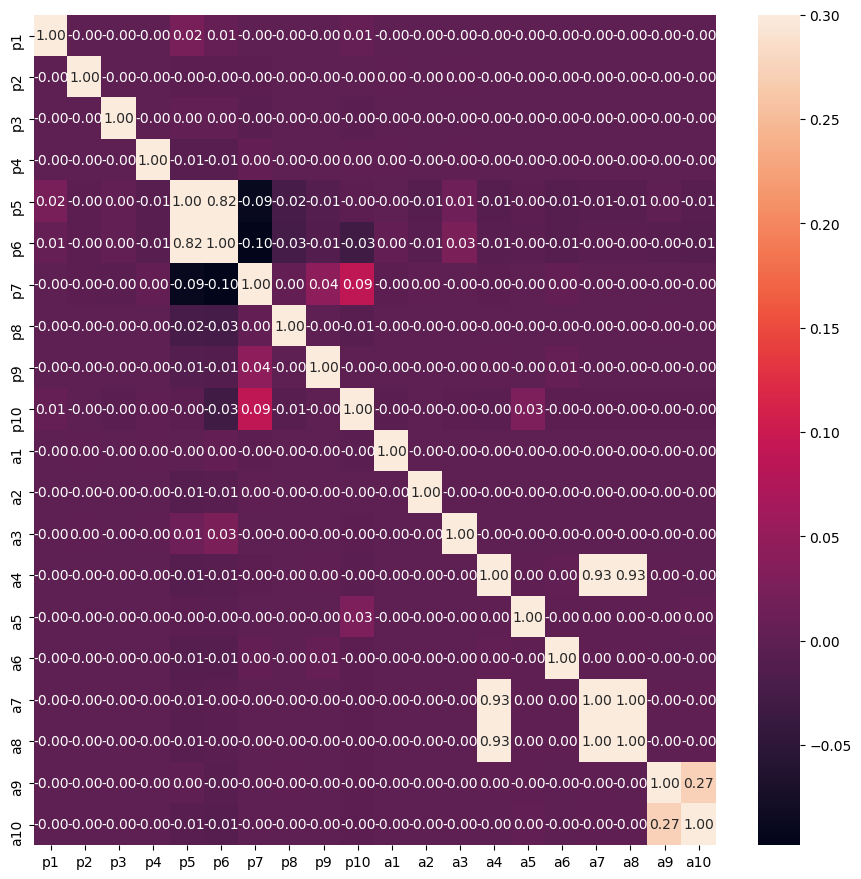

In [17]:
plt.figure(figsize=(11, 11),dpi=100)
corrmat = train.corr()
sns.heatmap(corrmat,
            vmax=0.3, 
            annot=True,#图中数字文本显示
            fmt=".2f",#格式化输出图中数字，即保留小数位数等          
           )

# 预处理

In [18]:
# train 分离 parameter 和 attribute
# train只包含p系列特征
col_attr = ['a{}'.format(i) for i in range(1, 11)]
attr = train[col_attr]
train = train.drop(col_attr, axis=1)

# 特征工程

In [19]:
# rounding
round_fmt = {1: 11, 2: 11, 3: 11, 4: 11, 5: 8,
             6: 8, 7: 8, 8: 8, 9: 8, 10: 8}
for i, r in round_fmt.items():
    train['p{}'.format(i)] = train['p{}'.format(i)].round(r)
    test['p{}'.format(i)] = test['p{}'.format(i)].round(r)

In [20]:
# transform log2
# 对数转换和归一化后存在负数，影响加减乘除的结果
# 需要测试对数转换前的效果
train = train.apply(np.log2)
attr = attr.apply(np.log2)
test = test.apply(np.log2)
gc.collect()

65

In [21]:
# 删除 p1-p4，保留 p5-p10
train.drop(columns=['p{}'.format(i) for i in range(1, 5)], inplace=True)
test.drop(columns=['p{}'.format(i) for i in range(1, 5)], inplace=True)
gc.collect()

20

In [22]:
print(train.shape, test.shape)

(12934, 6) (6000, 6)


# predict a4-a6 and p9
## p9
p9特征：train中只有17个不同的取值，test中只有14个不同的取值，是一个类别特征

In [23]:
train['p9'].unique()

array([ -0.75369838,  -4.26952583,   6.27795664,   2.76212913,
        -7.78535313,   9.79378415, -11.30119222,   8.0358704 ,
         1.00421537,   4.52004288,  12.25486341,  16.82543918,
        14.01277717,  27.37292172,  13.30961167,  20.3412667 ,
        11.55169791])

In [24]:
test['p9'].unique()

array([ -0.75369838,          nan,   2.76212913,  -4.26952583,
         4.52004288,   6.27795664,   9.79378415,  -7.78535313,
         8.0358704 ,   1.00421537, -11.30119222,  13.30961167,
        27.37292172,  12.25486341,  11.55169791])

对于p9，test中的取值，train中都出现了

In [25]:
set(test['p9'].unique()) - set(train['p9'].unique())

{nan}

In [26]:
set(train['p9'].unique()) - set(test['p9'].unique())

{14.01277717033098, 16.825439181400963, 20.34126669523821}

In [27]:
# lbl = LabelEncoder()
# lbl.fit(train['p9'])
# train['p9'] = lbl.transform(train['p9'])
# test['p9'] = lbl.transform(test['p9'])

In [28]:
test_notnull = test.loc[test['p9'].notnull(), :]

lbl = LabelEncoder()
lbl.fit(list(test_notnull['p9']) + list(train['p9']))
test_notnull['p9'] = lbl.transform(test_notnull['p9'])
train['p9'] = lbl.transform(train['p9'])
test.loc[test['p9'].notnull(), 'p9'] = test_notnull['p9']
del test_notnull
gc.collect()

0

In [29]:
train.head()

,p5,p6,p7,p8,p9,p10
0,-11.213036,-10.674110,11.15894,-4.819815,3,0.014905
1,-10.103131,-8.704548,11.15894,-4.819815,3,0.014905
2,-10.103131,-8.985913,11.15894,-4.819815,3,0.014905
3,-10.103131,-8.704548,11.15894,-4.819815,3,0.014905
4,-10.103131,-8.704548,11.15894,-4.819815,3,0.014905


In [30]:
test.head()

,p5,p6,p7,p8,p9,p10
0,4.166890,4.238250,-2.717298,-4.819815,3.0,3.330572
1,-0.589785,-1.670418,-4.699618,4.157854,3.0,-4.248095
2,-0.589785,-1.951783,-4.699618,4.157854,3.0,-4.248095
3,1.154329,1.143234,-4.699618,1.551434,NaN,0.014905
4,1.629997,1.424599,-4.699618,1.551434,NaN,-1.406095


In [31]:
parameter = 'p9'

In [32]:
p9 = train[parameter]
train.drop(parameter, axis=1, inplace=True)
gc.collect()

80

In [33]:
# df 保留原始特征
df = train.join(p9)

In [34]:
test_notnull = test.loc[test['p9'].notnull(), :]
test_notnull.drop('p9', axis=1, inplace=True)
gc.collect()

40

### LGB

In [35]:
best_hp = {
    'boosting_type': 'gbdt',
    'num_leaves': 111,
    'max_depth': -1,
    'learning_rate': 0.1,
    'n_estimators': 639,
    'subsample_for_bin': 200000,
    'objective': 'multiclass',
    'min_split_gain': 0,
    'min_child_weight': 0.001,
    'min_child_samples': 5,
    'subsample': 1.0,
    'subsample_freq': 0,
    'colsample_bytree': 1,
    'reg_alpha': 0.20174465129035402,
    'reg_lambda': 0.18200878389736302,
    'n_jobs': -1,
    'silent': True,
    'importance_type': 'gain',
    'num_class': 17
}

In [36]:
m = lgb.LGBMClassifier().set_params(**best_hp)
m.fit(train, p9)

LGBMClassifier(colsample_bytree=1, importance_type='gain', min_child_samples=5,
               min_split_gain=0, n_estimators=639, num_class=17, num_leaves=111,
               objective='multiclass', reg_alpha=0.20174465129035402,
               reg_lambda=0.18200878389736302)

In [37]:
res = m.predict(test_notnull)

In [38]:
test.loc[test['p9'].isnull(), 'p9'] = res.astype(int)

In [39]:
train = train.join(p9)
cols = ['p{}'.format(i) for i in range(5, 11)]
train = train[cols]
gc.collect()

64

## a4

In [40]:
attribute = 'a4'

In [41]:
# df 保留原始特征
df = train.join(attr[attribute])

In [42]:
best_hp = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 571,
    'verbosity': 1,
    'objective': 'reg:squarederror',
    'booster': 'dart',
    'n_jobs': -1,
    'gamma': 0,
    'min_child_weight': 1,
    'max_delta_step': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'reg_alpha': 6.345561548486771,
    'reg_lambda': 2.808394786832976,
    'scale_pos_weight': 1,
    'base_score': 0.5,
    'importance_type': 'gain',
    'num_round': 223
}

In [43]:
x_trn, x_val, y_trn, y_val = train_test_split(train, attr.a4, test_size=1000, random_state=2020)
m = xgb.XGBRegressor().set_params(**best_hp)
m.fit(x_trn, y_trn)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=571, n_jobs=-1, num_parallel_tree=1, num_round=223,
             random_state=0, reg_alpha=6.345561548486771,
             reg_lambda=2.808394786832976, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=1)

In [44]:
# 保存模型
joblib.dump(m,f'../model/tp3_{attribute}.m')

['../model/tp3_a4.m']

## a5

In [45]:
attribute = 'a5'

In [46]:
df = train.join(attr[attribute])

In [47]:
best_hp = {
    'max_depth': 4,
    'learning_rate': 0.1,
    'n_estimators': 749,
    'verbosity': 1,
    'objective': 'reg:squarederror',
    'booster': 'dart',
    'n_jobs': -1,
    'gamma': 0,
    'min_child_weight': 1,
    'max_delta_step': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'reg_alpha': 7.819025434063891,
    'reg_lambda': 0.005996946163704,
    'scale_pos_weight': 1,
    'base_score': 0.5,
    'importance_type': 'gain',
    'num_round': 934
}

In [48]:
x_trn, x_val, y_trn, y_val = train_test_split(train, attr.a5, test_size=1000, random_state=2020)
m = xgb.XGBRegressor().set_params(**best_hp)
m.fit(x_trn, y_trn)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=749, n_jobs=-1, num_parallel_tree=1, num_round=934,
             random_state=0, reg_alpha=7.819025434063891,
             reg_lambda=0.005996946163704, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=1)

In [49]:
# 保存模型
joblib.dump(m,f'../model/tp3_{attribute}.m')

['../model/tp3_a5.m']

## a6

In [50]:
attribute = 'a6'

In [51]:
df = train.join(attr[attribute])

In [52]:
best_hp = {
    'max_depth': 4,
    'learning_rate': 0.1,
    'n_estimators': 731,
    'verbosity': 1,
    'objective': 'reg:squarederror',
    'booster': 'dart',
    'n_jobs': -1,
    'gamma': 0,
    'min_child_weight': 1,
    'max_delta_step': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'reg_alpha': 9.299861941127418,
    'reg_lambda': 8.762447153395918,
    'scale_pos_weight': 1,
    'base_score': 0.5,
    'importance_type': 'gain',
    'num_round': 917
}

In [53]:
x_trn,x_val,y_trn,y_val = train_test_split(train, attr.a6, test_size=1000, random_state=2020)
m = xgb.XGBRegressor().set_params(**best_hp)
m.fit(x_trn, y_trn)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=731, n_jobs=-1, num_parallel_tree=1, num_round=917,
             random_state=0, reg_alpha=9.299861941127418,
             reg_lambda=8.762447153395918, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=1)

In [54]:
# 保存模型
joblib.dump(m, f'../model/tp3_{attribute}.m')

['../model/tp3_a6.m']

# attribute stacking

In [55]:
# stacking 建立 attr 特征
cv = KFold(6, shuffle=True, random_state=1)
attrs = ['a{}'.format(i) for i in range(4, 7)]

# trn_res DataFrame, 结果为index为原始index，列为a4, a5, a6, 最后通过索引关联到train中去
# tst_res DataFrame, 结果为index为原始index，列为a4, a5, a6, 最后通过索引关联到train中去
trn_res = None
tst_res = None
for attribute in attrs:
    print(attribute)
    m = joblib.load('../model/tp3_{}.m'.format(attribute))
    trn_attr = None
    tst_attr = None
    # trn_attr DataFrame, 结果为index为原始index，列为attribute
    # tst_attr np.array, 结果为预测的结果的均值
    for index, (trn_idx, val_idx) in enumerate(cv.split(train, attr[attribute])):
        x_trn, x_val = train.iloc[trn_idx], train.iloc[val_idx]
        y_trn, y_val = attr[attribute].iloc[trn_idx], attr[attribute].iloc[val_idx]
        m.fit(x_trn, y_trn)
        if trn_attr is None:
            trn_attr = np.c_[val_idx, m.predict(x_val)]  # np.c_ 左右相加，要求行数相等
            tst_attr = m.predict(test) / cv.n_splits
        else:
            trn_attr = np.r_[trn_attr, np.c_[val_idx, m.predict(x_val)]]  # np.r_ 上下相加，要求列数相等
            tst_attr += m.predict(test) / cv.n_splits
    trn_attr = pd.DataFrame(trn_attr).set_index(0)
    trn_attr.index = trn_attr.index.astype('int')
    trn_attr.columns = [attribute]
    if trn_res is None:
        trn_res = trn_attr
        tst_res = tst_attr
    else:
        trn_res = trn_res.join(trn_attr)
        tst_res = np.c_[tst_res, tst_attr]  # np.c_ 左右相加，要求行数相等

a4
a5
a6


In [56]:
train = train.join(trn_res)
tst_res = pd.DataFrame(tst_res)
tst_res.columns = ['a{}'.format(i) for i in range(4, 7)]
test = test.join(tst_res)

In [57]:
train.head()

,p5,p6,p7,p8,p9,p10,a4,a5,a6
0,-11.213036,-10.674110,11.15894,-4.819815,3,0.014905,2.019327,-0.651384,6.201127
1,-10.103131,-8.704548,11.15894,-4.819815,3,0.014905,2.536971,-1.641581,7.933536
2,-10.103131,-8.985913,11.15894,-4.819815,3,0.014905,3.259028,-1.860353,8.495710
3,-10.103131,-8.704548,11.15894,-4.819815,3,0.014905,3.892282,-1.066517,8.557544
4,-10.103131,-8.704548,11.15894,-4.819815,3,0.014905,3.920868,-1.655179,9.300926


In [58]:
test.head()

,p5,p6,p7,p8,p9,p10,a4,a5,a6
0,4.166890,4.238250,-2.717298,-4.819815,3.0,3.330572,-2.291499,-4.262832,3.180320
1,-0.589785,-1.670418,-4.699618,4.157854,3.0,-4.248095,0.143043,1.017900,-1.537889
2,-0.589785,-1.951783,-4.699618,4.157854,3.0,-4.248095,0.345481,0.844886,-1.189510
3,1.154329,1.143234,-4.699618,1.551434,3.0,0.014905,-0.519402,0.927536,-2.377372
4,1.629997,1.424599,-4.699618,1.551434,3.0,-1.406095,-1.484348,-0.219659,-2.680024


In [59]:
# save data
save_path = '../data/tp6.h5'
train.to_hdf(save_path, 'train')
target.to_hdf(save_path, 'target')
test.to_hdf(save_path, 'test')
attr.to_hdf(save_path, 'attr')
group.to_hdf(save_path, 'group')

# predict label

In [60]:
# load data
load_path = '../data/tp6.h5'
train = pd.read_hdf(load_path, 'train')
target = pd.read_hdf(load_path, 'target')
test = pd.read_hdf(load_path, 'test')
attr = pd.read_hdf(load_path, 'attr')
group = pd.read_hdf(load_path, 'group')
gc.collect()

81

In [61]:
def create_uid(df, cols, uid_name):
    df[uid_name] = df[cols[0]].astype(str)
    if len(cols) > 1:
        for c in cols[1:]:
            df[uid_name] = df[uid_name] + df[c].astype(str)
    return df


def uid_aggregation(train, test, main_cols, uid, agg_method):
    for main_col in main_cols:
        new_col_name = uid + '_' + main_col + '_' + agg_method
        train[new_col_name] = train.groupby([uid])[main_col].transform(agg_method)
        test[new_col_name] = test.groupby([uid])[main_col].transform(agg_method)


def frequency_encoding(train, test, cols):
    for c in cols:
        new_col_name = c + '_freq'
        train[new_col_name] = train[c].map(train[c].value_counts())
        test[new_col_name] = test[c].map(test[c].value_counts())


def nunique_encoding(train, test, main_cols, col):
    for main_col in main_cols:
        new_col_name = main_col + '_' + col + '_nunique'
        train[new_col_name]= train[col].map(train.groupby(col)[main_col].nunique())
        test[new_col_name]= test[col].map(test.groupby(col)[main_col].nunique())

In [62]:
# a4, a5, a6特征保留3位小数
for c in range(4, 7):
    col = 'a' + str(c)
    train[col] = train[col].round(3)
    test[col] = test[col].round(3)
gc.collect()

# creat uids
for key, value in {'uid1': ['p5', 'p6'], 'uid2': ['p7', 'p9', 'p10'],
                   'uid3': ['p5', 'p6', 'p7', 'p8', 'p9'], 'uid4': ['p10', 'p9', 'p8', 'p7']}.items():
    train = create_uid(train, cols=value, uid_name=key)
    test = create_uid(test, cols=value, uid_name=key)
    
# apply uid_aggregation
uid_aggregation(train, test, main_cols=['a4','a5'], uid='p7', agg_method='mean')
uid_aggregation(train, test, main_cols=['a4','a5','a6'], uid='uid4', agg_method='mean')
uid_aggregation(train, test, main_cols=['a4'], uid='uid4', agg_method='std')
uid_aggregation(train, test, main_cols=['p5','p6'], uid='uid4', agg_method='sum')

# apply frequency_encoding
frequency_encoding(train, test, cols=['p7', 'p8', 'p10'])

# apply unique_encoding
nunique_encoding(train, test, main_cols=['p8', 'p9', 'p10'], col='p7')
nunique_encoding(train, test, main_cols=['p9'], col='p8')
nunique_encoding(train, test, main_cols=['uid2', 'uid3'], col='uid1')
nunique_encoding(train, test, main_cols=['uid3'], col='uid2')

# a4 + a5 + a6
train['a4_plus_a5_plus_a6'] = train['a4'] + train['a5'] + train['a6']
test['a4_plus_a5_plus_a6'] = test['a4'] + test['a5'] + test['a6']

# majic_fe
train['majic_fe'] = train['uid4_p5_sum'] * train['uid4_p6_sum']
test['majic_fe'] = test['uid4_p5_sum'] * test['uid4_p6_sum']

# drop_cols
drop_cols = ['uid1', 'uid2', 'uid3', 'uid4', 'uid4_p5_sum', 'uid4_p6_sum']
train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)
gc.collect()

0

In [63]:
best_hp = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 203,
    'verbosity': 1,
    'objective': 'multi:softmax',
    'booster': 'dart',
    'n_jobs': -1,
    'gamma': 0,
    'min_child_weight': 1,
    'max_delta_step': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'reg_alpha': 6.736871781492226,
    'reg_lambda': 0.073512560432491,
    'scale_pos_weight': 1,
    'base_score': 0.5,
    'num_class': 4,
    'num_round': 295
}

In [64]:
oof = np.zeros((train.shape[0], 4))
prediction = np.zeros((test.shape[0], 4))

seeds = [123456, 87654, 676767]
num_model_seed = 3

for model_seed in range(num_model_seed):
    print("开始训练第%d个模型：" % (model_seed + 1))
    oof_cat = np.zeros((train.shape[0], 4))
    prediction_cat = np.zeros((test.shape[0], 4))
    skf = StratifiedKFold(n_splits=5, random_state=seeds[model_seed], shuffle=True)
    for index, (train_index, test_index) in enumerate(skf.split(train, target)):
        print("正在训练第%d折" % (index + 1))
        train_x, test_x = train.iloc[train_index], train.iloc[test_index]
        train_y, test_y = target.iloc[train_index], target.iloc[test_index]
        gc.collect()
        m = xgb.XGBClassifier().set_params(**best_hp).set_params(n_jobs=-1, learning_rate=0.05)
        m.fit(train_x, train_y) # xgb需要接受的是字典
        # 线下预测
        oof_cat[test_index] += m.predict_proba(test_x)
        # 线上预测
        prediction_cat += m.predict_proba(test) / skf.n_splits
        gc.collect()
    oof += oof_cat / num_model_seed
    prediction += prediction_cat / num_model_seed
    print('logloss', log_loss(pd.get_dummies(target).values, oof_cat))
    print('acc', accuracy_score(target, np.argmax(oof_cat, axis=1)))
print("*" * 30)
print('mean_logloss', log_loss(pd.get_dummies(target).values, oof))
print('mean_acc', accuracy_score(target, np.argmax(oof, axis=1)))

group_size=50
mname='CCF_model_xgb'
res_prob = pd.DataFrame(np.c_[group, prediction])  # np.c_ 左右相加，要求行数相等
res_prob.columns=['Group', 'Fail ratio', 'Pass ratio', 'Good ratio', 'Excellent ratio']
res_prob = res_prob[['Group', 'Excellent ratio','Good ratio', 'Pass ratio','Fail ratio']]
res_prob =(res_prob.groupby('Group').sum() / group_size).reset_index()
res_prob.to_csv('../sub/{}_prob.csv'.format(mname), index=False, encoding='utf-8')

开始训练第1个模型：
正在训练第1折
正在训练第2折
正在训练第3折
正在训练第4折
正在训练第5折
logloss 1.0500998759789058
acc 0.5496366166692439
开始训练第2个模型：
正在训练第1折
正在训练第2折
正在训练第3折
正在训练第4折
正在训练第5折
logloss 1.0490238778394991
acc 0.5495593010669553
开始训练第3个模型：
正在训练第1折
正在训练第2折
正在训练第3折
正在训练第4折
正在训练第5折
logloss 1.0490068792627605
acc 0.551646822328746
******************************
mean_logloss 1.0475657105802867
mean_acc 0.5514921911241688
